In [12]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

In [13]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
file_dir = '/content/drive/MyDrive/데이콘/데이콘 항공편 지연/데이콘_항공편_지연'

In [15]:
import numpy as np
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [17]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [18]:
csv_to_parquet(file_dir + '/train.csv', 'train')
csv_to_parquet(file_dir + '/test.csv', 'test')

train Done.
test Done.


In [19]:
train = pd.read_parquet('/content/train.parquet')
test = pd.read_parquet('/content/test.parquet')
sample_submission = pd.read_csv(file_dir+'/sample_submission.csv', index_col = 0)

                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006   0.109006
Carrier_Code(IATA)        108993   0.108993
Estimated_Departure_Time  108984   0.108984
Airline                   106527   0.106527
Destination_State         106523   0.106523
Origin_State              106505   0.106505
Destination_Airport            0   0.000000
Distance                       0   0.000000
Destination_Airport_ID         0   0.000000
ID                             0   0.000000
Month                          0   0.000000
Origin_Airport_ID              0   0.000000
Origin_Airport                 0   0.000000
Diverted                       0   0.000000
Cancelled                      0   0.000000
Day_of_Month                   0   0.000000
Tail_Number                    0   0.000000
                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040

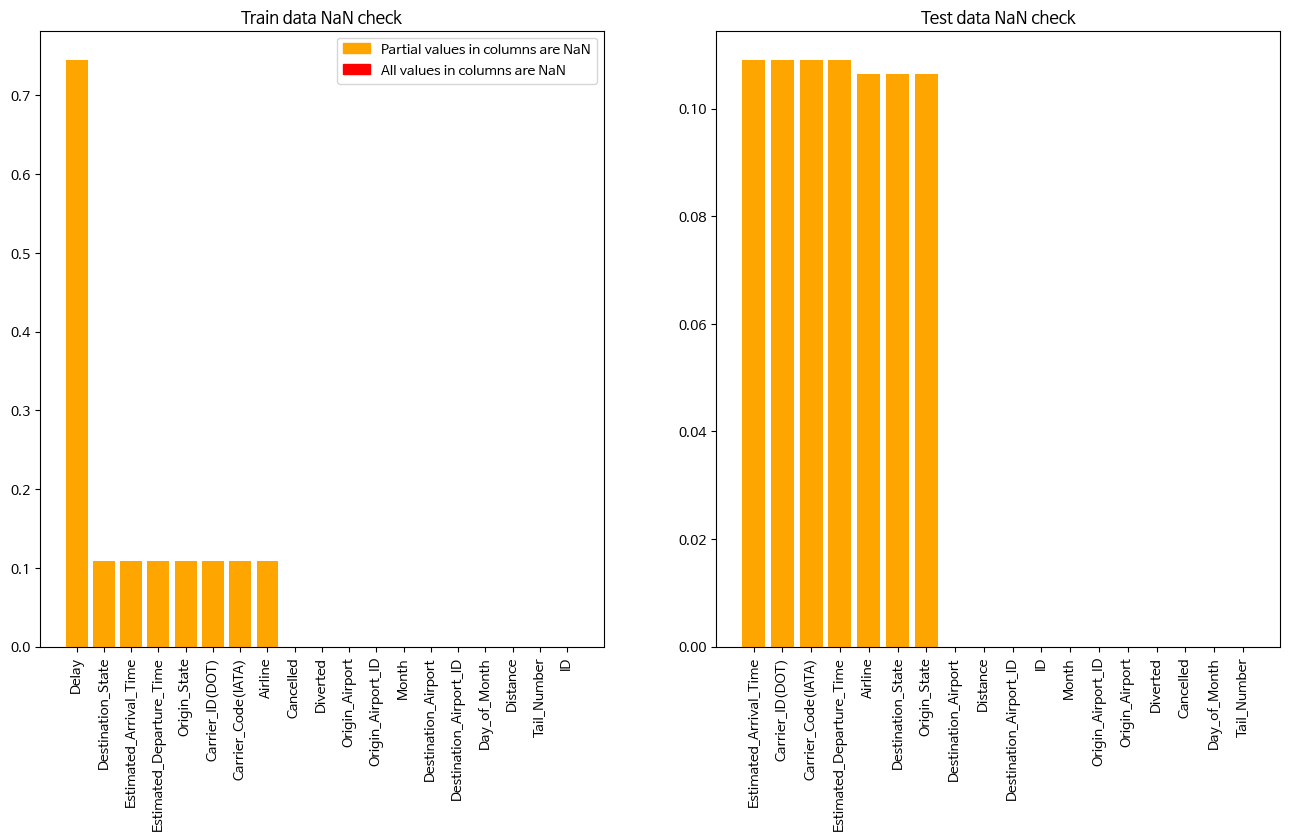

In [20]:
import matplotlib

matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(test_row_NaN)
print(train_row_NaN)
plt.show()

기존 train 데이터로 self training을 진행하여 null이 있는 열을 학습시켜야함.
순서는 null이 적은 값부터 많은 순서대로 학습 <br>
Airline > Carrier_ID(DOT) > Carrier_Code(IATA) > Estimated_Departure_Time > Estimated_Arrival_Time > delay <br>  

In [ ]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

fill_list = ['Airline', 'Carrier_ID(DOT)','Carrier_Code(IATA)','Estimated_Departure_Time','Estimated_Arrival_Time','delay']
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']
oridinary_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

# Train 데이터에서 null이 없는 열들 중 라벨링(not int)이 필요한 열들 순차적으로 정리
add_list = {}
for i in range(len(fill_list)): 
    if i == 0:
        add_list[i] = qual_col
    else:       
        add_list[i] = add_list[i-1] + [fill_list[i-1]]

train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

for i in range(len(fill_list)): 
    # 라벨링 준비
    label_st = train_lb.drop(columns = [fill_list[i]])
    train_st = train_lb[(train_lb[fill_list[i]].astype(str) != 'None')].drop(columns = [fill_list[i]])
    X_nan = train_lb[(train_lb[fill_list[i]].astype(str) == 'None')].drop(columns = [fill_list[i]])
    test_nan = test_lb[(test_lb[fill_list[i]].astype(str) == 'None')].drop(columns = [fill_list[i]])

    # 라벨링이 안된 원소들 라벨링
    for j in add_list[i]:
        le = LabelEncoder()
        le=le.fit(label_st[j])
        for label in np.unique(test[j].dropna()):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        train_lb[j] = le.transform(train_lb[j])
        train_st[j]=le.transform(train_st[j])
        X_nan[j]=le.transform(X_nan[j])
        test_lb[j]=le.transform(test_lb[j])    

    # 라벨링을 통해 null이 없었던 columns을 통해서 self_training
    X = train_st[oridinary_col]
    target_col = oridinary_col+ [fill_list[i]]
    y = train_lb[(train_lb[fill_list[i]].astype(str) != 'None')][target_col][fill_list[i]]

    stclf = SelfTrainingClassifier(
        base_estimator = RandomForestClassifier(n_estimators = 100),
        verbose = True)
    stclf.fit(X, y)   

    # 결과값 삽입
    X_nan[fill_list[i]+'_pred'] = stclf.predict(X_nan[oridinary_col])
    test_nan[fill_list[i]+'_pred'] = stclf.predict(test_nan[oridinary_col])
    train_lb.loc[train_lb[fill_list[i]].astype(str) == 'None', fill_list[i]] = X_nan[fill_list[i]+'_pred']
    test_lb.loc[test_lb[fill_list[i]].astype(str) == 'None', fill_list[i]] = test_nan[fill_list[i]+'_pred']
    
    # 다음 self_training을 위해 열 변경
    oridinary_col + [fill_list[i]]


/usr/local/lib/python3.9/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [ ]:
import itertools
import pandas as pd
import datetime 
def feature_engineering(t):
	def to_time(time_list):
		Time = pd.Series(time_list).astype(str).str.zfill(4)
		Time = Time.replace('2400','0000')
		return [datetime.datetime.strptime(i, '%H%M').strftime("%H:%M") if i != '0nan' else np.NaN for i in Time] 
	time_list = [i if str(i) == 'nan' else str(int(i))  for i in t['Estimated_Departure_Time'] ]
	time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in t['Estimated_Arrival_Time'] ]
	t['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
	t['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)
	
	# 예상 비행시간 만들기 (분으로 만들기)
	est_time = []
	for i,j in zip(t['Estimated_Arrival_Time_HH:MM'], t['Estimated_Departure_Time_HH:MM']):
		if str(i) != 'nan' and str(j) != 'nan':
			if (datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M")).total_seconds()/60 >= 0:
				est_time.append((datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M")).total_seconds()/60)
			else:
				time = datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M") + datetime.datetime.strptime('23:59', "%H:%M") + datetime.timedelta(minutes=1)
				est_time.append(datetime.timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60)
		else:
			est_time.append(np.NaN)
			
	# 예상 출발, 도착시간 그룹 화
	def time_gb(x):		
		if x >= 600 and x <= 659:
			return '0600-0659'
		elif x>=1400 and x<=1459:
			return '1400-1459'
		elif x>=1200 and x<=1259:
			return '1200-1259'
		elif x>=1500 and x<=1559:
			return '1500-1559'
		elif x>=1900 and x<=1959:
			return '1900-1959'
		elif x>=900 and x<=959:
			return '0900-0959'
		elif x>=1000 and x<=1059:
			return  '1000-1059'
		elif x>=2000 and x<=2059:
			return '2000-2059'
		elif x>=1300 and x<=1359:
			return '1300-1359'
		elif x>=1100 and x<=1159:
			return '1100-1159'
		elif x>=800 and x<=859:
			return '0800-0859'
		elif x>=2200 and x<=2259:
			return '2200-2259'
		elif x>=1600 and x<=1659:
			return '1600-1659'
		elif x>=1700 and x<=1759:
			return '1700-1759'
		elif x>=2100 and x<=2159:
			return '2100-2159'
		elif x>=700 and x<=759:
			return '0700-0759'
		elif x>=1800 and x<=1859:
			return '1800-1859'
		elif x>=1 and x<=559:
			return '0001-0559'
		elif x>=2300 and x<=2400:
			return '2300-2400'

	t['Dep_time_gb'] = t['Estimated_Departure_Time'].dropna().apply(time_gb)
	t['Arr_time_gb'] = t['Estimated_Arrival_Time'].dropna().apply(time_gb)
	
	# 예상 출발, 도착시간 그룹 화
	def distance_gb(x):
		if x < 700 :
			return 'short_route'
		elif x>=700 and x<3000:
			return 'mid_route'
		elif x>=3000:
			return 'long_route'        
	t['route_gb'] = t['Distance'].apply(distance_gb)
	
	# State 채우기

	# 값이 없는 특정 State 채우기
	origin_state = train[['Origin_Airport','Origin_Airport_ID','Origin_State']].dropna()
	origin_state = origin_state.drop_duplicates()
	origin_state.columns = ['Origin_Airport','Origin_Airport_ID','F_Origin_State']
	Destination_state = train[['Destination_Airport','Destination_Airport_ID','Destination_State']].dropna()
	Destination_state = Destination_state.drop_duplicates()
	Destination_state.columns = ['Destination_Airport','Destination_Airport_ID','F_Destination_State']

	t = pd.merge(t, origin_state, on = ['Origin_Airport','Origin_Airport_ID'], how = 'outer')
	t = pd.merge(t, Destination_state, on = ['Destination_Airport','Destination_Airport_ID'], how = 'outer')
	

	mask = (t['Destination_Airport'] == 'YNG')&(t['Destination_Airport_ID'] == 16133)
	value = 'Indiana'
	t.loc[mask,'F_Destination_State'] = t.loc[mask,'F_Destination_State'].fillna(value) 
	t = t.drop(columns=['Origin_State', 'Destination_State'])
	t = t.rename(columns={'F_Origin_State': 'Origin_State', 'F_Destination_State': 'Destination_State'})
 
	# 누락된 Airline 임의로 채우기 (외부 데이터 사용 불가능!!)

	#master_dil = '/content/drive/MyDrive/데이콘/데이콘 항공편 지연/데이콘_항공편_지연/ReleasableAircraft.2020/MASTER.txt'
	#data = []
	#with open(master_dil, 'r', encoding = "utf-8-sig") as file:
	#	data.append(file.readlines())    
	#data = list(itertools.chain(*data))  
	#data = [line.split(',') for line in data]
	#col = data[0]
	#df = pd.DataFrame(data, columns = col)
	#df['Tail_Number'] = ['N' + i for i in df['N-NUMBER']]
	#Airline = df[['N-NUMBER', 'Tail_Number', 'NAME']]
	#t = pd.merge(t, Airline, left_on = 'Tail_Number', right_on = 'Tail_Number', how = 'left')
	#t = pd.merge(t, Airline[['N-NUMBER', 'NAME']], left_on = 'Tail_Number', right_on = 'N-NUMBER', how = 'left')

	#Airline_mode = pd.DataFrame(t.groupby(['Tail_Number'])['Airline'].agg(pd.Series.mode))
	#Airline_mode.rename(columns = {'Airline' : 'mode_Airline'})
 
	#t = pd.merge(t, Airline_mode, on = 'Tail_Number', how = 'left')
	
	#t['New_Airline'] = np.where(t['Tail_Number'][:1] == 'N', t['NAME_y'], t['Airline_x'])
	#t['New_Airline'] = np.where((t['New_Airline'].astype(str) == 'nan') & (t['Airline_x'].astype(str) == 'nan'), t['NAME_x'], t['Airline_x'])
	#t['New_Airline'] = np.where((t['New_Airline'].astype(str) == 'None'), t['Airline_y'], t['Airline_x'])
	#t = t.drop(columns = ['Origin_State', 'Destination_State','Airline','N-NUMBER_x', 'N-NUMBER_y', 'NAME_x','NAME_y','mode_Airline'])
	return t

In [ ]:
train = feature_engineering(train)
test = feature_engineering(test)

In [ ]:
train